In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'pancreas_scv_model.cpt',
                               '--exp-name', 'CohAE_pancreas_scv',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', 'X',
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_pancreas_scv', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=1.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='pancreas_scv_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='clusters', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Ductal", "Ngn3 low EP"),
    ("Ngn3 low EP", "Ngn3 high EP"),
    ("Ngn3 high EP", "Pre-endocrine"), 
    ("Pre-endocrine", "Alpha"), 
    ("Pre-endocrine", "Beta"), 
    ("Pre-endocrine", "Delta"), 
    ("Pre-endocrine", "Epsilon")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scv.datasets.pancreas()
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [7]:
adata.obs.clusters.unique()

['Pre-endocrine', 'Ductal', 'Alpha', 'Ngn3 high EP', 'Delta', 'Beta', 'Ngn3 low EP', 'Epsilon']
Categories (8, object): ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta', 'Alpha', 'Delta', 'Epsilon']

  0%|          | 0/3696 [00:00<?, ?cells/s]

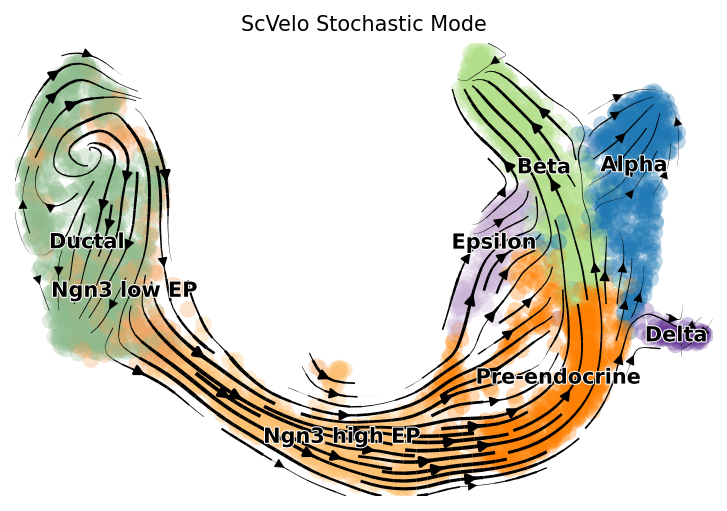

# Cross-Boundary Transition Score (A->B)
{('Ductal', 'Ngn3 low EP'): 0.126304, ('Ngn3 low EP', 'Ngn3 high EP'): 0.18903114, ('Ngn3 high EP', 'Pre-endocrine'): 0.22138557, ('Pre-endocrine', 'Alpha'): 0.18845135, ('Pre-endocrine', 'Beta'): 0.23058629, ('Pre-endocrine', 'Delta'): 0.18872781, ('Pre-endocrine', 'Epsilon'): 0.09088845}
Total Mean: 0.17648209631443024
# Cross-Boundary Velocity Coherence (A->B)
{('Ductal', 'Ngn3 low EP'): 0.9767997, ('Ngn3 low EP', 'Ngn3 high EP'): 0.9718368, ('Ngn3 high EP', 'Pre-endocrine'): 0.8773561, ('Pre-endocrine', 'Alpha'): 0.75469714, ('Pre-endocrine', 'Beta'): 0.69584286, ('Pre-endocrine', 'Delta'): 0.81724924, ('Pre-endocrine', 'Epsilon'): 0.8742646}
Total Mean: 0.8525781035423279
# Cross-Boundary Direction Correctness (A->B)
{('Ductal', 'Ngn3 low EP'): 0.09267981561499823, ('Ngn3 low EP', 'Ngn3 high EP'): 0.8999989251136972, ('Ngn3 high EP', 'Pre-endocrine'): 0.751448700382228, ('Pre-endocrine', 'Alpha'): 0.6725987616938394, ('Pre-endocrine', 'Beta

In [8]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  # legend_loc="right margin", 
                                 vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=150, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Loss: (Total) 20.392597, (AE) 20.352980, (LR) 1.00 * 0.039618: 100%|██████████| 20000/20000 [16:49<00:00, 19.81it/s]


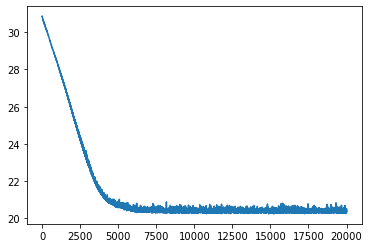

In [9]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/3696 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_pancreas_pojection.png


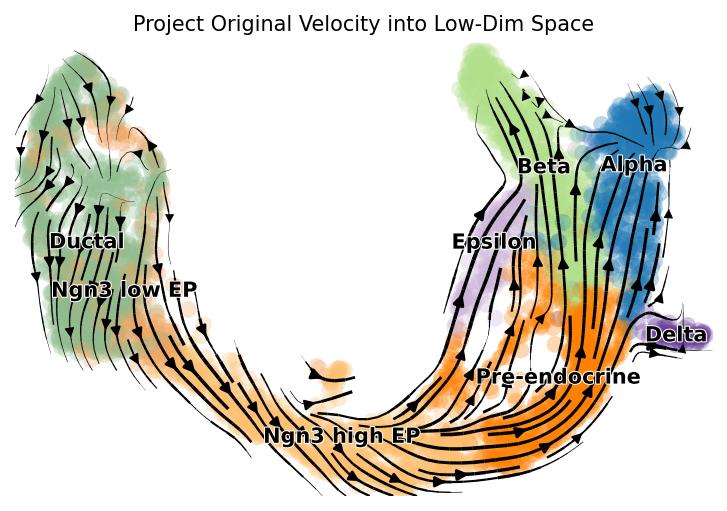

# Cross-Boundary Transition Score (A->B)
{('Ductal', 'Ngn3 low EP'): 0.40506485, ('Ngn3 low EP', 'Ngn3 high EP'): 0.6761153, ('Ngn3 high EP', 'Pre-endocrine'): 0.7211131, ('Pre-endocrine', 'Alpha'): 0.79523283, ('Pre-endocrine', 'Beta'): 0.74217016, ('Pre-endocrine', 'Delta'): 0.8299546, ('Pre-endocrine', 'Epsilon'): 0.4658132}
Total Mean: 0.662209153175354
# Cross-Boundary Velocity Coherence (A->B)
{('Ductal', 'Ngn3 low EP'): 0.9676256, ('Ngn3 low EP', 'Ngn3 high EP'): 0.99849796, ('Ngn3 high EP', 'Pre-endocrine'): 0.9998769, ('Pre-endocrine', 'Alpha'): 0.9970425, ('Pre-endocrine', 'Beta'): 0.99878484, ('Pre-endocrine', 'Delta'): 0.98936355, ('Pre-endocrine', 'Epsilon'): 0.99054205}
Total Mean: 0.9916762113571167
# Cross-Boundary Direction Correctness (A->B)
{('Ductal', 'Ngn3 low EP'): 0.0048810536451405736, ('Ngn3 low EP', 'Ngn3 high EP'): 0.7910164984969114, ('Ngn3 high EP', 'Pre-endocrine'): 0.625670757528238, ('Pre-endocrine', 'Alpha'): 0.5674653481652604, ('Pre-endocrine', 'Beta'

In [10]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset= not args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis=args.vis_key, color=args.vis_type_col,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=150,
                                    save='pancreas_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]


  0%|          | 0/1266 [00:00<?, ?gene/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

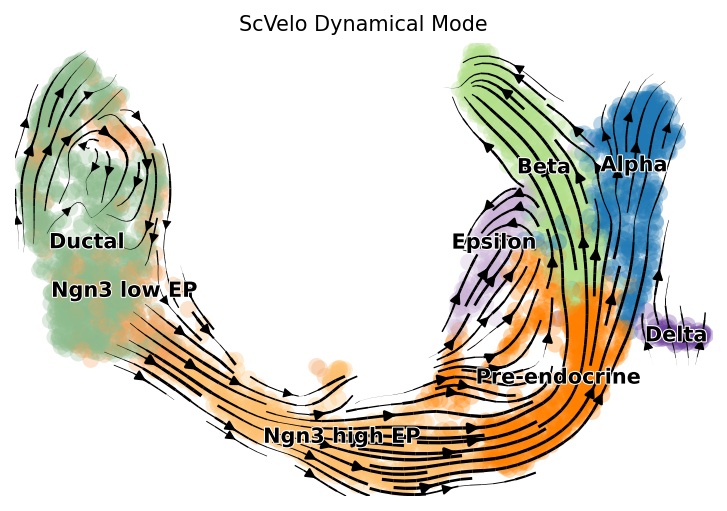

# Cross-Boundary Transition Score (A->B)
{('Ductal', 'Ngn3 low EP'): 0.05275616, ('Ngn3 low EP', 'Ngn3 high EP'): 0.17781222, ('Ngn3 high EP', 'Pre-endocrine'): 0.35986316, ('Pre-endocrine', 'Alpha'): 0.31625727, ('Pre-endocrine', 'Beta'): 0.3013959, ('Pre-endocrine', 'Delta'): 0.17647874, ('Pre-endocrine', 'Epsilon'): 0.1397658}
Total Mean: 0.2177613079547882
# Cross-Boundary Velocity Coherence (A->B)
{('Ductal', 'Ngn3 low EP'): 0.8214776317787715, ('Ngn3 low EP', 'Ngn3 high EP'): 0.7758056560919626, ('Ngn3 high EP', 'Pre-endocrine'): 0.8733989350426655, ('Pre-endocrine', 'Alpha'): 0.8798730752527966, ('Pre-endocrine', 'Beta'): 0.8745300587254078, ('Pre-endocrine', 'Delta'): 0.8381258942272377, ('Pre-endocrine', 'Epsilon'): 0.8186974899771258}
Total Mean: 0.840272677299424
# Cross-Boundary Direction Correctness (A->B)
{('Ductal', 'Ngn3 low EP'): 0.05871314600601333, ('Ngn3 low EP', 'Ngn3 high EP'): 0.8677428504612359, ('Ngn3 high EP', 'Pre-endocrine'): 0.6794245276040332, ('Pre-endocr

In [11]:
adata = scv.datasets.pancreas()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)